<a href="https://colab.research.google.com/github/XRX-San/Kaust-Labs/blob/main/Exercises/day_4/Day4_exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![image.png](https://i.imgur.com/a3uAqnb.png)

# 🖼️ **Day 4 Exercise: CIFAR-10 Classification Using Pytorch**
---
In this lab, you will:
- Use the **CIFAR-10** image dataset
- Build a **five-layer neural network classifier**
- Train the model to classify images into 10 categories
- Evaluate the model’s performance on test data


##📚 **Import Libraries**


In [1]:
from torchvision.datasets import CIFAR10
from torchvision.transforms.functional import to_tensor
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch
from torch.optim import AdamW

## 📊 **About CIFAR-10**


<img src="https://miro.medium.com/v2/0*BdetXYemwXwOqNTs.jpg" width="60%">

- Built-in image dataset provided by PyTorch  
- Contains **60,000 color images** with size **32 × 32 pixels**  
- Images are **RGB (3 channels)**, giving a tensor shape of **(3, 32, 32)**  
  (unlike MNIST, which uses grayscale images of 1 channel)  
- Split into **50,000 training images** and **10,000 test images**  
- Includes **10 classes**: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck  




### 🔹**Prepare Data**


> loading **CIFAR-10** dataset by creating separate **training** and **testing** dataset objects and applying a tensor transformation to each color image.


In [2]:
# Training dataset
train_dataset = CIFAR10(root='./datasets', train=True, transform=to_tensor, download=True)
# Testing dataset
test_dataset = CIFAR10(root='./datasets', train=False, transform=to_tensor, download=True)

# Print one sample from the dataset
sample_image, sample_label = train_dataset[0]
print(f"Image shape: {sample_image.shape}")  # (3, 32, 32)
print(f"Label: {sample_label}")

100%|██████████| 170M/170M [00:13<00:00, 12.3MB/s]


Image shape: torch.Size([3, 32, 32])
Label: 6


> Using **DataLoaders** to group the training and testing datasets into mini-batches and feed them efficiently to the model during training and evaluation.

In [3]:
# DataLoader for training data
train_loader = DataLoader( train_dataset, batch_size=32, shuffle=True, num_workers=2)
# DataLoader for test data
test_loader = DataLoader( test_dataset, batch_size=32, shuffle=False, num_workers=2)

# Get the first batch from the training DataLoader
X_batch, y_batch = next(iter(train_loader))
print(f"Training batch input shape: {X_batch.shape}")
print(f"Training batch labels shape: {y_batch.shape}")

Training batch input shape: torch.Size([32, 3, 32, 32])
Training batch labels shape: torch.Size([32])


> Lets display some images !


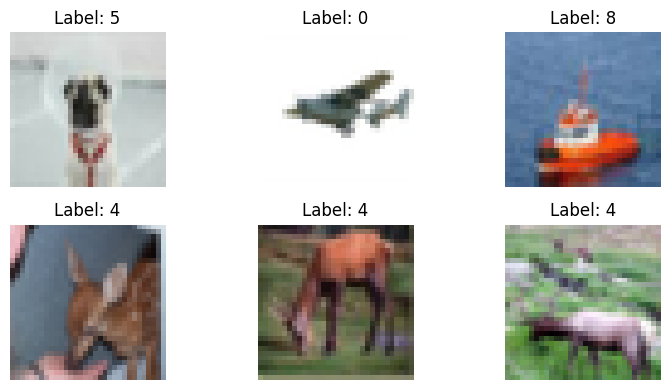

In [4]:
# Get one batch of images and labels
images, labels = next(iter(train_loader))

# Display the first 6 images in the batch
plt.figure(figsize=(8, 4))

for i in range(6):
    plt.subplot(2, 3, i + 1)

    # Convert from (C, H, W) to (H, W, C) for matplotlib
    img = images[i].permute(1, 2, 0)

    plt.imshow(img)
    plt.title(f"Label: {labels[i].item()}")
    plt.axis('off')

plt.tight_layout()
plt.show()

> Data now is ready for the model ! you'll now build the model class.

---

### 🔹 **TODO: Model Class**

- Implement a **five-layer neural network classifier**
- Define the layers and activation functions inside the model class
- Consider what output activation function to use for this task




In [9]:
class NN5Layer(nn.Module):

    def __init__(self, input_dim, hidden_dim, output_dim):
        super(NN5Layer, self).__init__()

        # TODO: What are the dimensions of the first layer? (hint: features? hidden neurons?)
        self.layer1 = nn.Linear(input_dim, hidden_dim)

        # TODO: What are the dimensions from previous and next layer?
        self.layer2 = nn.Linear(hidden_dim, hidden_dim)

        # TODO: What are the dimensions from previous and next layer?
        self.layer3 = nn.Linear(hidden_dim, hidden_dim)

        # TODO: What are the dimensions from previous and next layer?
        self.layer4 = nn.Linear(hidden_dim, hidden_dim)

        # TODO: What are the dimensions of previous and output layer? (hint: hidden neurons? num of classes?)
        self.layer5 = nn.Linear(hidden_dim, output_dim)

        # activation function for non-linearity
        self.relu = nn.ReLU()

    # Defines how input data flows through the network
    def forward(self, x):
        # Layer 1: TODO
        z1 = self.layer1(x)
        a1 = self.relu(z1)

        # Layer 2 TODO
        z2 = self.layer2(a1)
        a2 = self.relu(z2)

        # Layer 3 TODO
        z3 = self.layer3(a2)
        a3 = self.relu(z3)

        # Layer 4 TODO
        z4 = self.layer4(a3)
        a4 = self.relu(z4)

        # Output layer TODO
        z5 = self.layer5(a4)

        # TODO: are we missing output activation function? (hint: Loss Function)
        # No, CrossEntropyLoss expects raw logits.

        return z5



> Recall: Although we conceptually use **Softmax** for multiclass classification,
it is **not included inside the model** when using `CrossEntropyLoss`.

---



### 🔹**Training Loop**

In [6]:
def train_one_epoch(model, optimizer, criterion, train_loader, device):
    # Set the model to training mode
    model.train()

    running_loss = 0.0

    for X_batch, y_batch in train_loader:
        # Move batch to the selected device
        X_batch = X_batch.view(X_batch.size(0), -1).to(device)
        y_batch = y_batch.to(device)

        # Forward pass
        # TODO: make predictions
        outputs = model(X_batch)
        # TODO: compute loss
        loss = criterion(outputs,y_batch) # <YOUR CODE HERE>

        # Backward pass & optimization
        optimizer.zero_grad()   # Clear previous gradients
        loss.backward()         # Compute gradients
        optimizer.step()        # Update model parameters

        running_loss += loss.item()

    # Average loss over all batches
    avg_loss = running_loss / len(train_loader)

    return avg_loss

### 🔹**Validation Loop**

In [7]:
def validate(model, criterion, test_loader, device):
    # Set the model to evaluation mode
    model.eval()

    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            # Move data to device
            X_batch = X_batch.view(X_batch.size(0), -1).to(device)
            y_batch = y_batch.to(device)

            # Forward pass
            # TODO: make predictions
            outputs =  model(X_batch)
            # TODO: compute loss
            loss = criterion(outputs,y_batch)# <YOUR CODE HERE>
            running_loss += loss.item()

            # TODO: Apply Softmax to get probabilities
            probabilities = F.softmax(outputs,dim = 1)

            # TODO: Multiclass predictions
            predicted = torch.argmax(probabilities, dim = 1)

            # Accuracy calculation
            correct += (predicted == y_batch).sum().item()
            total += y_batch.size(0)

    avg_loss = running_loss / len(test_loader)
    # TODO: how do we calculate accuracy?
    accuracy = correct / total

    return avg_loss, accuracy


### 🔹**Running Training**

In [8]:
# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model parameters
# TODO: What are input features ? (hint: flatten using channel, height, width)
input_dim = 3 * 32 * 32

# TODO: choose number of hidden neurons
hidden_dim = 64

# TODO: what are the number of classes ?
output_dim = 10

# TODO: Instantiate model (what are the model class inputs?)
model = NN5Layer(input_dim,hidden_dim,output_dim).to(device)

# TODO: Print the model architecture
print("Model Architecture:\n")
print(model)

# Calculate the total number of trainable parameters
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nTotal trainable parameters: {total_params}")

AttributeError: module 'torch.nn' has no attribute 'linear'

In [ ]:
# TODO: choose number of epochs, increase it if you have gpus :)
num_epochs = 4
# TODO: choose a learning rate (try different values and evaluate results)
learning_rate = 0.01

# TODO: Define criterion (loss function) (hint: what loss do we use for multiclass ?)
criterion = nn.CrossEntropyLoss()
# TODO: Define optimizer(what is updated during training?)
optimizer = AdamW(model.parameters(), learning_rate)

In [ ]:
# Run Training
train_losses = []
val_losses = []
val_accuracies = []

print('Starting Training...')
for epoch in range(num_epochs):
    # Train one epoch
    train_loss = train_one_epoch(model, optimizer, criterion, train_loader, device)

    # Validate
    val_loss, val_accuracy = validate(model, criterion, test_loader, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

print('Training Complete!')

In [ ]:
# Plotting results
plt.figure(figsize=(7, 5))

plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

## We're Done!



## 🚀 **Challenge**
Try to improve your model and **reach an accuracy above 50%** by tuning the architecture or hyperparameters like hidden neurons, number of epochs, learning rate, and optimizer.

### 💡 **Note**
MLPs are not ideal for image data.  
In **Stage 3**, you will learn about **Convolutional Neural Networks (CNNs)**, which are better suited for images.


##✨ **Exam Day is Tomorrow, Good Luck!**


## **Contributed by : Yara Alzahrani**